$$\newcommand{\tket}{t\!\left|ket\right\rangle}$$

#### Silas Dilkes
#### Cambridge Quantum 
### silas.dilkes@cambridgequantum.com

### Developing and executing error-mitigated NISQ algorithms across devices and simulators

# 3) Circuit Execution with Error Mitigation

## What is TKET?

### The tket framework is a software platform for the development and execution of gate-level quantum computation, providing state-of-the-art performance in circuit compilation. The toolset is designed to aid platform-agnostic software and extract the most out of the available NISQ devices of today. <br>

<br>
Important context - many components of quantum devices are noisy - this leads to errors in quantum computation at the gate-level. 

## What do we mean by noisy devices?

* Noise can be anything physical that unexpectedly effects the logical state of a qubit
* No quantum device can be considered an isolated quantum system - coupling with environment can perturb system, i.e. Environmental Decoherence
* Miscalibration of results can cause physical manipulation of qubits to not match expected logical changes
* An error at the quantum circuit level may manifest due to a combination of different noise sources


## How do we define good compiler performance?

Good compiler performance produces circuits that accrue fewer errors when executed on some quantum processor:

If logical circuit's A and B have the same unitary but A has fewer gates, do we expect A to provide better quality
results when run on a quantum processor?

If logical circuit's A and B have the same unitary but A has fewer two-qubit gates, do we expect A to provide better quality results when run on a quantum processor?

If physical circuit's A and B have the same unitary but A has fewer two-qubit gates, do we expect A to provide better quality results when run on a quantum processor?

1) **Quantum Circuit Construction** <br>
2) **Quantum Circuit Compilation** <br>
3) **Quantum Circuit Execution** <br>

## How can we improve device results? 


## What is Error Mitigation?

* The name error-mitigation often functions as an umbrella term for a wide range of loosely-connected techniques at all levels of the quantum computing stack. The loose thread between such methods is that they mitigate errors in quantum computation, caused by noise in quantum devices in some capacity. 
<br><br>
* Many of these methods are defined in the quantum circuit model - a reasonable restriction to make as often errors can be succesfully supressed by understanding how they effect computation at this level. An understanding of calibration and control problems at the hardware level is not always needed. 
<br><br>
* At this level mitigation methods typically fit in to two distinctions - those that modify a distribution of counts of basis states, and those that modify the expectation value of some observable.

# Qermit

### github.com/CQCL/qermit
`pip install qermit` 

* Can be used with any `pytket` `Backend`
<br> <br>
* Mitigation schemes can be easily swapped out 
<br> <br>
* Mitigation schemes can be easily composed

In [1]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

guadalupe_backend = IBMQEmulatorBackend('ibmq_guadalupe', hub='partner-cqc', group='internal', project='default')

In [2]:
from pytket import Qubit, Circuit, OpType
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit, Graph
from pytket.routing import NoiseAwarePlacement
from pytket.extensions.qiskit.backends.ibm import _tk1_to_x_sx_rz
from pytket.transform import Transform
from typing import List, Tuple, Callable
import numpy as np

def graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
#     qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    qpo_dict = {}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5*cost_angle
    return QubitPauliOperator(qpo_dict)


def gen_superposition_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

def gen_qaoa_max_cut_circuit(edges: List[Tuple[int, int]], 
                     n_nodes: int, 
                     mixer_angles: List[float], 
                     cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)

    qaoa_circuit = gen_superposition_circuit(n_nodes)
    
    for cost, mixer in zip(cost_angles, mixer_angles):
        mixer_ham = QubitPauliOperator(
            {
                QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)
            }
        )
        cost_ham = graph_to_cost_hamiltonian(edges, cost)
        
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

In [3]:
from pytket.passes import (
    SequencePass,
    RebaseCustom,
    CXMappingPass,
    FullPeepholeOptimise,
    OptimisePhaseGadgets,
    RemoveRedundancies,
)

guadalupe_info = guadalupe_backend.backend_info

guadalupe_placer = NoiseAwarePlacement(arc=guadalupe_info.architecture,
                                       node_errors=guadalupe_info.averaged_node_gate_errors,
                                       link_errors=guadalupe_info.averaged_edge_gate_errors,
                                       readout_errors=guadalupe_info.averaged_readout_errors)

ibm_rebase = RebaseCustom(
    {OpType.CX},
    Circuit(2).CX(0, 1),
    {OpType.X, OpType.SX, OpType.Rz},
    _tk1_to_x_sx_rz,
)

guadalupe_mapping_pass = CXMappingPass(
    guadalupe_info.architecture,
    guadalupe_placer,
    directed_cx=False
)

sequence_pass = SequencePass([FullPeepholeOptimise(), guadalupe_mapping_pass, ibm_rebase, RemoveRedundancies()])

# MitRes

In [4]:
from qermit import MitRes, CircuitShots
from qermit.taskgraph import Wire

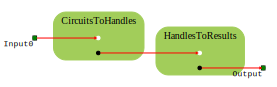

In [5]:
mitres = MitRes(guadalupe_backend)
mitres.get_task_graph()

In [6]:
from pytket import Circuit

c = Circuit(2,2).H(0).CX(0,1).measure_all()

compiled_circuit = guadalupe_backend.get_compiled_circuit(c)

circuit_shots = CircuitShots(Circuit = compiled_circuit, Shots = 1000)

results = mitres.run([circuit_shots])

print(results[0].get_counts())

Counter({(1, 1): 501, (0, 0): 473, (1, 0): 15, (0, 1): 11})


In [7]:
from qermit import MitTask

def gen_sequence_pass_mittask(sequence_pass: SequencePass) -> MitTask:
    
    def task(circuit_shots: List[CircuitShots]) -> Tuple[List[CircuitShots]]:
        for cs in circuit_shots:
            sequence_pass.apply(cs.Circuit)
        return (circuit_shots,)
    
    return MitTask(_label="ApplySequencePass", _n_in_wires=1, _n_out_wires=1, _method=task)

sequence_mittask = gen_sequence_pass_mittask(sequence_pass)
print(sequence_mittask)

<MitTask::ApplySequencePass>


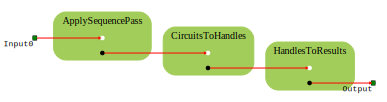

In [8]:
mitres.prepend(sequence_mittask)
mitres.get_task_graph()

In [9]:
c = Circuit(2,2).H(0).CX(0,1).measure_all()

circuit_shots = CircuitShots(Circuit = c, Shots = 1000)

results = mitres.run([circuit_shots])
print(results[0].get_counts())

Counter({(0, 0): 550, (1, 1): 430, (0, 1): 11, (1, 0): 9})


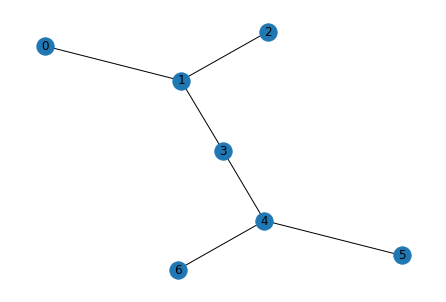

In [10]:
import networkx as nx

max_cut_graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

In [11]:
my_qaoa_circuit = gen_qaoa_max_cut_circuit(max_cut_graph_edges, 
                                           n_nodes, 
                                           [0.09322317, 0.34768547, 0.22499183], 
                                           [0.4353554, 0.86376827, 0.84328461])
my_qaoa_circuit.measure_all()

# without sequence pass
compiled_qaoa_circuit = guadalupe_backend.get_compiled_circuit(my_qaoa_circuit)
results_base = MitRes(guadalupe_backend).run([CircuitShots(compiled_qaoa_circuit, 5000)])

# with sequence pass
results_sequence = mitres.run([CircuitShots(my_qaoa_circuit, 5000)])

SPAM Mitigation - https://cqcl.github.io/qermit/manual/manual_mitres.html#spam-mitigation-in-qermit

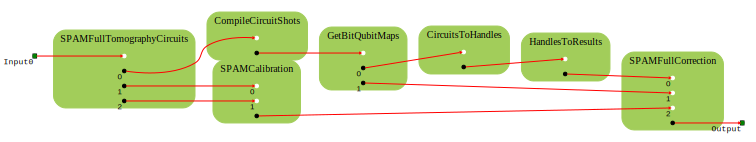

In [12]:
from qermit.spam import gen_UnCorrelated_SPAM_MitRes

spam_mitres = gen_UnCorrelated_SPAM_MitRes(guadalupe_backend, calibration_shots=2000)
spam_mitres.get_task_graph()

In [13]:
my_qaoa_circuit = gen_qaoa_max_cut_circuit(max_cut_graph_edges, 
                                           n_nodes, 
                                           [0.09322317, 0.34768547, 0.22499183], 
                                           [0.4353554, 0.86376827, 0.84328461])
my_qaoa_circuit.measure_all()

# run with spam mitigation
results_spam = spam_mitres.run([CircuitShots(my_qaoa_circuit, 5000)])

# MitEx

In [14]:
from qermit import MitEx, ObservableExperiment, ObservableTracker, AnsatzCircuit, SymbolsDict

mitex = MitEx(guadalupe_backend)

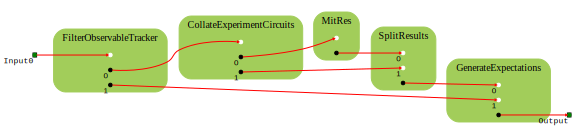

In [15]:
mitex.get_task_graph()

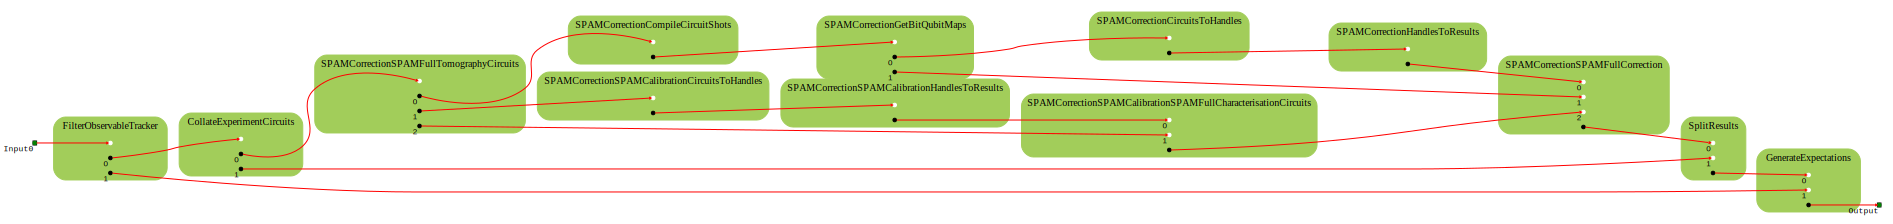

In [16]:
mitex_spam = MitEx(guadalupe_backend, mitres = spam_mitres)

mitex_spam.decompose_TaskGraph_nodes()
mitex_spam.get_task_graph()

In [17]:
my_qaoa_circuit = gen_qaoa_max_cut_circuit(max_cut_graph_edges, 
                                           n_nodes, 
                                           [0.09322317, 0.34768547, 0.22499183], 
                                           [0.4353554, 0.86376827, 0.84328461])

# get qubit pauli operator object for experiment
cost_ham_qpo = graph_to_cost_hamiltonian(max_cut_graph_edges, 1.0)

# AnsatzCircuit = Tuple[Circuit, int, Symbols]
ansatz_circuit = AnsatzCircuit(my_qaoa_circuit, 4000, SymbolsDict())

# Wrapper for QubitPauliOperator also holding measurement circuits
observable_tracker = ObservableTracker(cost_ham_qpo)

# Wrapper for full experiment
observable_experiment = ObservableExperiment(ansatz_circuit, observable_tracker)

In [18]:
results_exp_base = mitex.run([observable_experiment])

In [57]:
print(results_exp_base[0])
print(sum(results_exp_base[0]._dict.values()))

{(Zq[0], Zq[1]): 0.0290000000000000, (Zq[1], Zq[2]): 0.00975000000000004, (Zq[1], Zq[3]): 0.0270000000000000, (Zq[3], Zq[4]): 0.0112500000000000, (Zq[4], Zq[5]): 0.00224999999999997, (Zq[4], Zq[6]): 0.00400000000000000}
0.0832500000000000


In [58]:
ansatz_circuit = AnsatzCircuit(my_qaoa_circuit, 4000, SymbolsDict())
observable_tracker = ObservableTracker(cost_ham_qpo)
observable_experiment = ObservableExperiment(ansatz_circuit, observable_tracker)

results_exp_spam = mitex_spam.run([observable_experiment])

In [59]:
print(results_exp_spam[0])
print(sum(results_exp_spam[0]._dict.values()))

{(Zq[0], Zq[1]): 0.0234882558720639, (Zq[1], Zq[2]): 0.0257371314342829, (Zq[1], Zq[3]): 0.0474762618690655, (Zq[3], Zq[4]): 0.0397301349325337, (Zq[4], Zq[5]): 0.0207396301849075, (Zq[4], Zq[6]): 0.00399800099950021}
0.161169415292354


In [21]:
def gen_qaoa_instance(mitex: MitEx, graph_edges: List[Tuple[int, int]], shots: int, tracking: bool) -> 
    Callable[np.array, float]:
#     function returned by method for use in maximisation
    def qaoa_instance(gammasbetas :np.array) -> float:
        lengb = len(gammasbetas) // 2
        assert len(gammasbetas) % 2 == 0

        guess_mixer_angles = gammasbetas[: lengb]
        guess_cost_angles = gammasbetas[lengb: ]

        # step 1: get state guess
        preparation_circuit = gen_qaoa_max_cut_circuit(graph_edges, 
                                                       n_nodes, 
                                                       guess_mixer_angles, 
                                                       guess_cost_angles)

        # step 2: get problem hamiltonian
        ham = graph_to_cost_hamiltonian(graph_edges, 1.0)

        # step 3: get energy using MitEx
        ansatz_circuit = AnsatzCircuit(preparation_circuit, shots, SymbolsDict())
        observable_tracker = ObservableTracker(ham)
        observable_experiment = ObservableExperiment(ansatz_circuit, observable_tracker)
        
        result = mitex.run([observable_experiment])[0]
        
        energy = float(-1*sum(result._dict.values()) - len(graph_edges)*0.5)
        if tracking:
            print("|--Guess--|")
            print("| Energy: ", energy)
            print("| Mixer Angles: ", guess_mixer_angles)
            print("| Cost Angles: ", guess_cost_angles)
        return energy
    return qaoa_instance

In [22]:
from pytket.extensions.qiskit import AerBackend

mitex_qaoa_instance = gen_qaoa_instance(MitEx(AerBackend()), max_cut_graph_edges, 5000, True)

In [27]:
def maximise_angles_with_random_samples(samples: int, 
                                        layers: int, 
                                        qaoa_instance: Callable[np.array, float],
                                        tracking: bool) -> Tuple[np.array, np.array, float]:
#     guess a first set of angles
    max_mixer_angles = np.random.uniform(0, 1, layers)
    max_cost_angles = np.random.uniform(0, 1, layers)
    max_energy = -1*qaoa_instance(np.concatenate((max_mixer_angles, max_cost_angles)))
#     loop, guess, compare
    for i in range(1, samples):
        guess_mixer_angles = np.random.uniform(0, 1, layers)
        guess_cost_angles = np.random.uniform(0, 1, layers)
        guess_energy = -1*qaoa_instance(np.concatenate((max_mixer_angles, max_cost_angles)))
        if tracking:
            print("\nSample ", i)
            print("|--Guesses--|")
            print("| Energy: ", guess_energy)
            print("| Mixer Angles: ", guess_mixer_angles)
            print("| Cost Angles: ", guess_cost_angles)
            print("|----Max----|")
            print("| Energy: ", max_energy)
            print("| Mixer Angles: ", max_mixer_angles)
            print("| Cost Angles: ", max_cost_angles)
#         if new energy greater, set to max energy
        if guess_energy > max_energy:
            max_energy = guess_energy
            max_mixer_angles = guess_mixer_angles
            max_cost_angles = guess_cost_angles
    return (max_mixer_angles, max_cost_angles, max_energy)

In [28]:
solution = maximise_angles_with_random_samples(10, 3, mitex_qaoa_instance, True)

|--Guess--|
| Energy:  -2.7994
| Mixer Angles:  [0.21956152 0.55774569 0.69366996]
| Cost Angles:  [0.99570697 0.1081246  0.40363911]
|--Guess--|
| Energy:  -2.8242
| Mixer Angles:  [0.21956152 0.55774569 0.69366996]
| Cost Angles:  [0.99570697 0.1081246  0.40363911]

Sample  1
|--Guesses--|
| Energy:  2.8242
| Mixer Angles:  [0.71118745 0.15965685 0.74599877]
| Cost Angles:  [0.20584018 0.4447705  0.62825135]
|----Max----|
| Energy:  2.7994
| Mixer Angles:  [0.21956152 0.55774569 0.69366996]
| Cost Angles:  [0.99570697 0.1081246  0.40363911]
|--Guess--|
| Energy:  -2.08
| Mixer Angles:  [0.71118745 0.15965685 0.74599877]
| Cost Angles:  [0.20584018 0.4447705  0.62825135]

Sample  2
|--Guesses--|
| Energy:  2.08
| Mixer Angles:  [0.48588444 0.70800442 0.43450883]
| Cost Angles:  [0.27590869 0.57844817 0.30127586]
|----Max----|
| Energy:  2.8242
| Mixer Angles:  [0.71118745 0.15965685 0.74599877]
| Cost Angles:  [0.20584018 0.4447705  0.62825135]
|--Guess--|
| Energy:  -2.088
| Mixer An

In [29]:
print(solution)

(array([0.71118745, 0.15965685, 0.74599877]), array([0.20584018, 0.4447705 , 0.62825135]), 2.8242)


### Available MitEx TaskGraph generators

In [65]:
contrived_cost_ham = graph_to_cost_hamiltonian(max_cut_graph_edges, 0.3)
contrived_1_circuit = gen_term_sequence_circuit(contrived_cost_ham, Circuit(n_nodes))
Transform.DecomposeBoxes().apply(contrived_1_circuit)
render_circuit_jupyter(contrived_1_circuit)

In [36]:
def run_contrived_circuit(mitex: MitEx, shots: int) -> List[QubitPauliOperator]:
    contrived_cost_ham = graph_to_cost_hamiltonian(max_cut_graph_edges, 0.3)
    contrived_1_circuit = gen_term_sequence_circuit(contrived_cost_ham, Circuit(n_nodes))
    Transform.DecomposeBoxes().apply(contrived_1_circuit)
    
    observable_tracker = ObservableTracker(cost_ham_qpo)
    ansatz_circuit = AnsatzCircuit(contrived_1_circuit, shots, SymbolsDict())
    observable_experiment = ObservableExperiment(ansatz_circuit, observable_tracker)
    return mitex.run([observable_experiment])

In [37]:
from pytket.extensions.qiskit import AerBackend

observable_tracker = ObservableTracker(cost_ham_qpo)
observable_experiment = ObservableExperiment(ansatz_circuit, observable_tracker)

noiseless_results = run_contrived_circuit(MitEx(AerBackend()), 10000)
print("Estimated Expectation value is ", -1*sum(noiseless_results[0]._dict.values()))

Estimated Expectation value is  3.00000000000000


In [38]:
noisy_results = run_contrived_circuit(MitEx(guadalupe_backend), 10000)
print("Estimated Expectation value is ", -1*sum(noisy_results[0]._dict.values()))

Estimated Expectation value is  2.77780000000000


Error mitigation with Clifford quantum-circuit data, Czarnik, Arrasmith, Coles, Cincio, arXiv:2005.10189

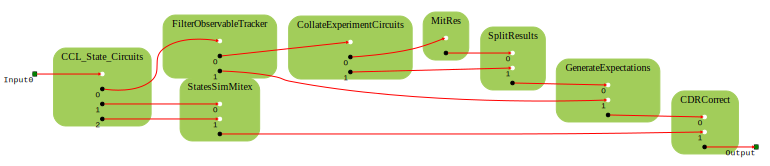

In [60]:
from qermit.clifford_noise_characterisation import gen_CDR_MitEx

cdr_mitex = gen_CDR_MitEx(device_backend = guadalupe_backend, 
                         simulator_backend = AerBackend(),
                         n_non_cliffords = 2,
                         n_pairs = 2,
                         total_state_circuits = 50)
cdr_mitex.get_task_graph()

In [40]:
cdr_noisy_results = run_contrived_circuit(cdr_mitex, 10000)
print("Estimated Expectation value is ", -1*sum(cdr_noisy_results[0]._dict.values()))

Estimated Expectation value is  3.00000000000000


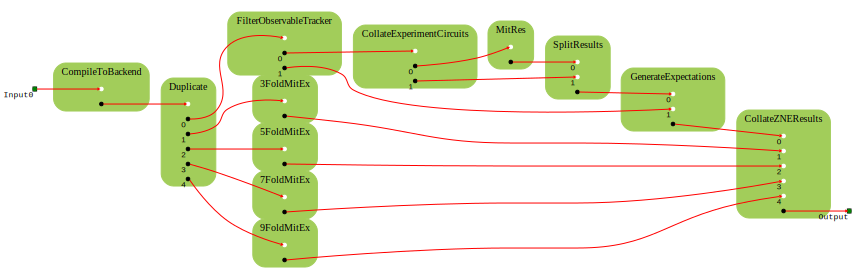

In [41]:
from qermit.zero_noise_extrapolation import gen_ZNE_MitEx

zne_mitex = gen_ZNE_MitEx(guadalupe_backend, noise_scaling_list = [3,5,7,9], rebase_pass = guadalupe_backend._rebase_pass)
zne_mitex.get_task_graph()

In [42]:
zne_noisy_results = run_contrived_circuit(zne_mitex, 10000)
print("Estimated Expectation value is ", -1*sum(zne_noisy_results[0]._dict.values()))

Estimated Expectation value is  2.43634000000000


### Run on a real device!

In [43]:
from pytket.extensions.qiskit import IBMQBackend

guadalupe_backend_real = IBMQBackend('ibmq_guadalupe', 
                                     hub='partner-cqc', 
                                     group='internal', 
                                     project='default')

In [44]:
noisy_device_results = run_contrived_circuit(MitEx(guadalupe_backend_real), 10000)
print("Estimated Expectation value is ", -1*sum(noisy_device_results[0]._dict.values()))

Job Status: job has successfully run
Estimated Expectation value is  2.68000000000000


In [45]:
cdr_mitex = gen_CDR_MitEx(device_backend = guadalupe_backend_real, 
                         simulator_backend = AerBackend(),
                         n_non_cliffords = 2,
                         n_pairs = 2,
                         total_state_circuits = 50)

In [46]:
cdr_noisy_results_device = run_contrived_circuit(cdr_mitex, 10000)
print("Estimated Expectation value is ", -1*sum(cdr_noisy_results_device[0]._dict.values()))

Job Status: job has successfully run
Job Status: job has successfully run
Estimated Expectation value is  3.00000000000000


# Thanks for listening!